# Statistical Experiments and Signficance Testing

The goal of this notebook is to explore an A/B testing dataset found on Kaggle. In this dataset, multiple users are shown the current web page (control group) while other users are shown a new page.A summary of the finding is presented below:
- The conversion of the control group is 12.03% and the conversion of the treatment group is 11.89%.
- There is a 89.5% that there is in fact a effect due to the treatment and that the discrepency is not just a result of chance (ie p-value of 0.105).
- By target in advance what the goal of the experiment is, the sample size can be greatly reduced, for example:
    - A sample of 64602 observations is necessary to have a 95% chance detecting a 5% increase in conversions with an alpha of 0.05.
    - A sample of 20000 observations is enough to have a 50% chance detecting a 5% increase in conversions with an alpha of 0.05.

# Table of Content
- [Import Libraries](#section#1)
    - [Functions](#section#2)
- [Import and look at the Data](#section#3)
    - [Section Summary](#section#4)
    - [Section Code](#section#5)
        - [Read the Data](#section#6)
        - [Look at the Data](#section#7)
        - [Estimate Conversions](#section#8)
- [Signficance Testing](#section#9)
    - [Section Summary](#section#10)
    - [Section Code](#section#11)
        - [Permutation Test](#section#12)
- [Power and Sample Size ](#section#13)
    - [Section Summary](#section#14)
    - [Section Code](#section#15)
        - [Required Sample Size with Given Parameters](#section#16)
        - [Effect of Power on Sample Size](#section#17)

# Import Libraries <a class="anchor" id="#section1"></a>
We first import all libraries used in this notebook.

In [53]:
# Statistics
import statsmodels.api as sm

# Data Manipulation
import numpy as np # play with arrays
import pandas as pd # play with dfs

# Data Vizualization and Exploration
import pandas_profiling # complete EDA in 1 line of code
import matplotlib.pyplot as plt # charting library
%matplotlib inline

# Utils
from tqdm.notebook import tqdm # progress bar in loops
import random

# Functions <a class="anchor" id="#section2"></a>
The functions used in this notebook are defined below. 

In [54]:

def permutation(x, nA, nB):
    '''
    Run a permutation test.
    There is a great vizual example of a permutation test here: https://www.jwilber.me/permutationtest/
    
    Arguments:
    x: combined dataset (A and B) in array form
    nA: group A size
    nB: group B size
    
    Returns:
    The difference the mean of a randomly sample group of size nA and a randomly sampled group of size nB.
    '''
    n = nA + nB
    idx_B = set(random.sample(range(n), nB))
    idx_A = set(range(n)) - idx_B
    return x.loc[idx_B].mean() - x.loc[idx_A].mean()

def sample_from_power(effect_size, power, control, alpha):
    '''
    Estimate required sample size to find a effect at a given power with a given alpha.
    
    Arguments:
    effect_size: effect size (for example 5% increase in conversions).
    power: probability of detecting a given effect size with a given sample size.
    control: control group value (for example 105 conversions in control group).
    alpha: signficance level at which the test will be conducted.
    
    Returns:
    The sample size required in the test to detect the effect at a given power and alpha.
    '''    
    effect_size = sm.stats.proportion_effectsize((1+effect_size)*control, control)
    analysis = sm.stats.TTestIndPower()
    result = analysis.solve_power(effect_size=effect_size,
                                  alpha=alpha,
                                  power=power,
                                  alternative='larger')
    return result

# Import and look at the Data <a class="anchor" id="#section3"></a>

## Section Summary <a class="anchor" id="#section4"></a>
The A/B testing dataset was found on Kaggle. <br>
Source: https://www.kaggle.com/zhangluyuan/ab-testing

In this section:
- The dataset is downloaded from Kaggle and read.
- The period of the test data cleanliness is checked.
- The convertion for each group was estimated.

This simple dataset consists of conbertion data for a group using an old landing page (the control group) and a group using a new landing page (the treatment group). Importing and briefly looking at the data leads to the following takeaways:
- The test data was collected between January 2nd and January 24th 2017. No seasonality effect will be considered in the analysis.
- The test contains a total od 294,478 clean data points. No data pre-processing is required.
- The control and treatment group both represent about 50% of the sample.
- The conversion of the control group is 12.03% and the conversion of the treatment group is 11.89%.

## Section Code <a class="anchor" id="#section5"></a>

### Read the Data <a class="anchor" id="#section6"></a>

In [55]:
df = pd.read_csv('ab_data.csv').sort_values(by='timestamp')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 294478 entries, 131228 to 193652
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 13.5+ MB


### Look at the Data <a class="anchor" id="#section7"></a>

In [56]:
pandas_profiling.ProfileReport(df).to_file('ab_testing.html')

Summarize dataset:   0%|          | 0/19 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

### Estimate Conversions <a class="anchor" id="#section8"></a>

In [57]:
conversions = df[df.converted==1].groupby('group').converted.count()
conversions

group
control      17723
treatment    17514
Name: converted, dtype: int64

In [58]:
sample_size = df.groupby('group').converted.count()
sample_size

group
control      147202
treatment    147276
Name: converted, dtype: int64

In [59]:
percent_convertion = conversions / sample_size
percent_convertion

group
control      0.120399
treatment    0.118920
Name: converted, dtype: float64

# Signficance Testing <a class="anchor" id="#section9"></a>

## Section Summary <a class="anchor" id="#section10"></a>
We have seen in the previous that the conversion is higher for the control group. Since we do not have information on the reason of the experiment in the dataset, we do not know if the new page is preferable in significant ways other than conversion. Examples of reasons could be:
- Performs better on some other metric not defined in this dataset.
- Esthetic of the new page better aligned with company branding.
- Any other reason that could tilt the balance in the favor of the new page

For this reason, we need to have the complete picture, ie know if the difference in conversion between the old and new landing page is significant. To do that, we will perform a permutation test.

In this section:
- A permutation test is done.
- the p-value is estimated (0.1045).
- The p-value of 0.1045 means that we would expect to achieve a result as extreme or more extreme than the result observed in the data by random chance 10.45% of the time.


## Section Code <a class="anchor" id="#section11"></a>

### Permutation Test <a class="anchor" id="#section12"></a>

In [60]:
permutation_differences = [permutation(df.converted, sample_size[0], sample_size[1]) for _ in tqdm(range(2000))]

  0%|          | 0/2000 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Permutation Test')

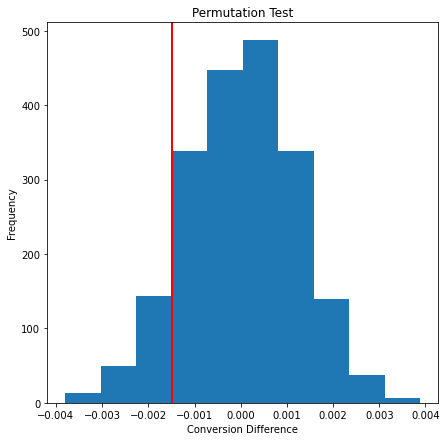

In [61]:
group_difference = percent_convertion[1]-percent_convertion[0]

fig, ax = plt.subplots(figsize=(7,7))
ax.hist(permutation_differences, bins=10)
ax.axvline(x=group_difference, color='red', lw=2)
ax.set_xlabel('Conversion Difference')
ax.set_ylabel('Frequency')
ax.set_title('Permutation Test')

In [62]:
p_value = (permutation_differences <= group_difference).sum() / len(permutation_differences)
print('The p-value is: ', p_value)

The p-value is:  0.1045


# Power and Sample Size 

## Section Summary <a class="anchor" id="#section13"></a>
A sample of close to 300,000 observations was available for the analysis. All of the data was used during the analysis. If I performed the experiment, I would have, before beginning the collection of data, estimated the required sample size. This step is especially important if the data collection is costly or requires time and effort.

Despite what many web testing guides would say, there is no general guidance to estimate the sample size, it depends mainly on the frequency with which the desired goal is attained. To calculate the required sample size, we need to specify 3 parameters:
- The effect size we want to detect (for example 5% increase in conversion)
- The signficance level (alpha) at which the test will be conducted (0.05 is the traditionnal value)
- The power (the probability of detecting a given effect size with a given sample size)

In the following section, we calculate the sample size to achieve have a 95% probability (power) of detecting a significant (alpha=0.05) 5% increase in conversion (effect size).
We also the variation in sample size required when changing the power. We get the following insights:
- A sample of 64602 observations is necessary to have a 95% chance detecting a 5% increase in conversions with an alpha of 0.05.
- A sample of 20000 observations is enough to have a 50% chance detecting a 5% increase in conversions with an alpha of 0.05.

## Section Code <a class="anchor" id="#section14"></a>

### Required Sample Size with Given Parameters <a class="anchor" id="#section15"></a>

In [63]:
effect_size = 0.05
power = 0.95
control = percent_convertion[0]
alpha = 0.05

sample_size = sample_from_power(effect_size, power, control, alpha)

print('The required sample to have a 95% change of detecting a 5% increase in conversion with an alpha of 0.05 is', round(sample_size), '.')

The required sample to have a 95% change of detecting a 5% increase in conversion with an alpha of 0.05 is 64602 .


### Effect of Power on Sample Size <a class="anchor" id="#section16"></a>

Text(0.5, 1.0, 'Sampling Effort vs Probability of Finding Effect')

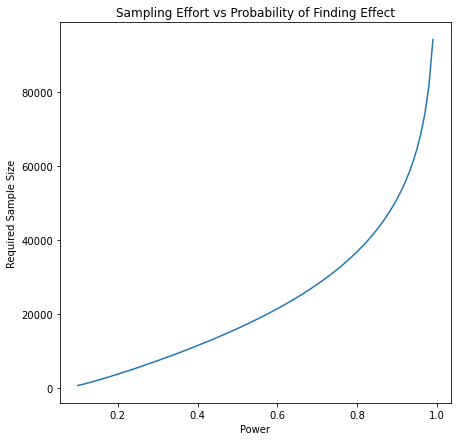

In [64]:
sample_vs_power = []
for i in range(10,100,1):
    power=i/100
    sample_size = sample_from_power(effect_size, power, control, alpha)
    sample_vs_power.append((power, sample_size))

sample_vs_power = pd.DataFrame(sample_vs_power)
sample_vs_power = sample_vs_power.set_index(0)

fig, ax = plt.subplots(figsize=(7,7))
ax.plot(sample_vs_power)
ax.set_xlabel('Power')
ax.set_ylabel('Required Sample Size')
ax.set_title('Sampling Effort vs Probability of Finding Effect')